In this notebook, we'll see how to use PyTorch to train a classifier to identify the presence of Pneumonia by looking at chest X Ray images. Through this project, we'll get familiar with the basics of transfer learning, PyTorch and convolutional neural networks.

**Contents**

- <a href='#1'>1. Import the necessary libraries</a>

- <a href='#2'>2. Read the dataset</a>

- <a href='#3'>3. Exploration of the data</a>

- <a href='#4'>4. Image Preprocessing</a>
   
- <a href='#5'>5. Data Iterators</a>

- <a href='#6'>6. Using Pre-Trained Models for Image Classification</a>

- <a href='#7'>7. Training the model </a>

- <a href='#7'>7. Saving and loading the model </a>

- <a href='#7'>7. Making Predictions </a>
 

In [1]:
!pip install torchsummary

<a id='1'>1. Import the necessary libraries</a>

In [2]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

import os
print(os.listdir("../input"))

['pytorch-pretrained-models', 'chest-xray-pneumonia']


<a id='2'>2. Read the dataset</a>

As we can see, the dataset has been divided into train, validation and test folders.

In [3]:
from subprocess import check_output
print(check_output(["ls", "/kaggle/input/chest-xray-pneumonia/chest_xray"]).decode("utf8"))

chest_xray
__MACOSX
test
train
val



In [4]:
datadir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
traindir = datadir + '/train/'
validdir = datadir + '/val/'
testdir = datadir + '/test/'

save_file_name = 'vgg16-chest-4.pt'
checkpoint_path = 'vgg16-chest-4.pth'

# Change to fit hardware
batch_size = 128

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


<a id='3'>3. Exploration of the data </a>

<Axes: xlabel='category'>

(array([0, 1]), [Text(0, 0, 'NORMAL'), Text(1, 0, 'PNEUMONIA')])

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Training Images by Category')

       category  height  width
0     PNEUMONIA     712   1024
1     PNEUMONIA    1016   1424
2     PNEUMONIA    1208   1376
3     PNEUMONIA    1256   1336
4     PNEUMONIA     516    895
...         ...     ...    ...
5211     NORMAL    2326   2091
5212     NORMAL    1136   1484
5213     NORMAL    1430   1762
5214     NORMAL    1067   1316
5215     NORMAL    1272   1592

[5216 rows x 3 columns]     category  n_train  n_valid  n_test
1     NORMAL     1341        8     234
0  PNEUMONIA     3875        8     390


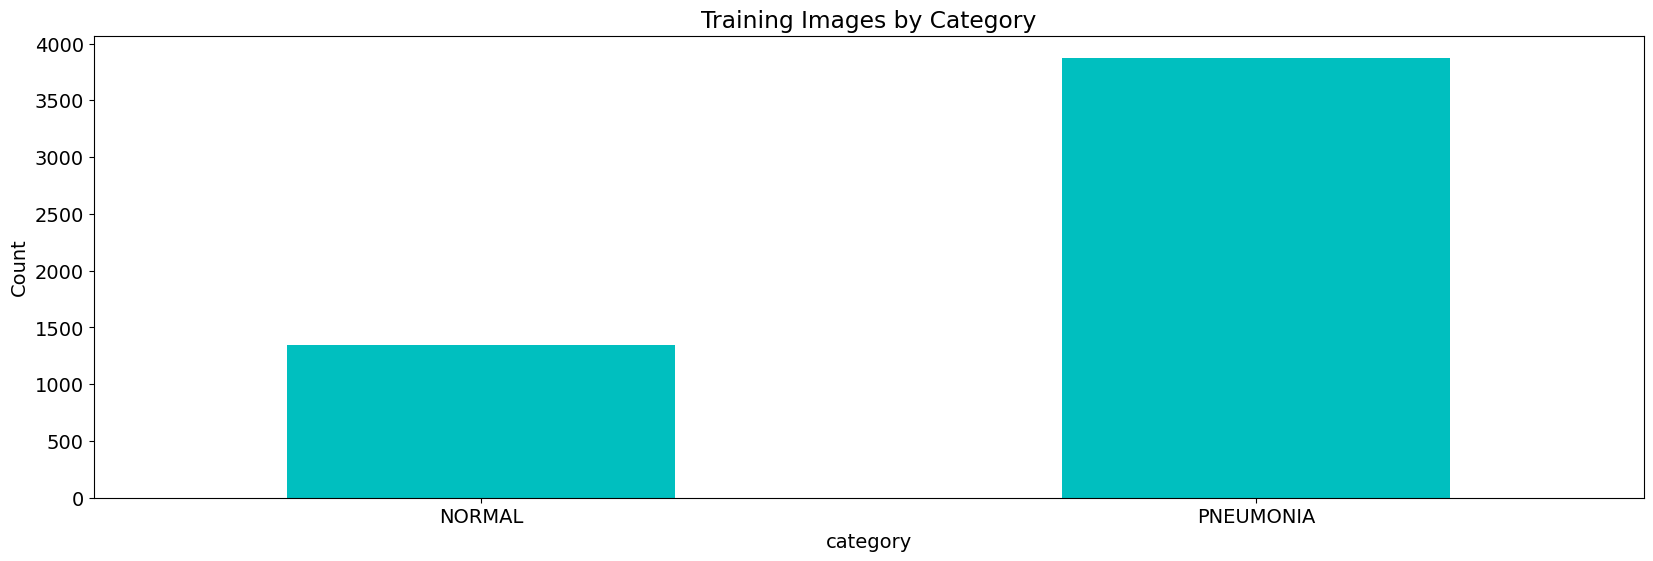

In [5]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    if not d.startswith('.'):
        categories.append(d)

        # Number of each image
        train_imgs = os.listdir(traindir + d)
        valid_imgs = os.listdir(validdir + d)
        test_imgs = os.listdir(testdir + d)
        n_train .append(len(train_imgs))
        n_valid.append(len(valid_imgs))
        n_test.append(len(test_imgs))

        # Find stats for train images
        for i in train_imgs:
            if not i.startswith('.'):
                img_categories.append(d)
                img = Image.open(traindir + d + '/' + i)
                img_array = np.array(img)
                # Shape
                hs.append(img_array.shape[0])
                ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws}
    )
#cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.set_index('category')['n_train'].plot.bar(
    color='c', figsize=(20, 6))
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Training Images by Category')
print(image_df,cat_df)

## What the Plot Describes: "Average Size Distribution"
This creates a KDE plot (Kernel Density Estimate plot) that shows:

The distribution of average image height in pixels (one curve)

The distribution of average image width in pixels (another curve)
### What the KDE plot shows:
Imagine the plot like a smoothed version of a histogram that shows where most of your image sizes lie.

Here’s what each curve represents:

- Blue curve (label: "Average Height")
This shows how the heights of images are distributed, per category.

- Orange curve (label: "Average Width")
This shows how the widths of images are distributed, per category.

The X-axis = number of pixels
The Y-axis = probability density (how common that pixel size is)


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='height', ylabel='Density'>

<Axes: xlabel='height', ylabel='Density'>

Text(0.5, 0, 'Pixels')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Average Size Distribution')

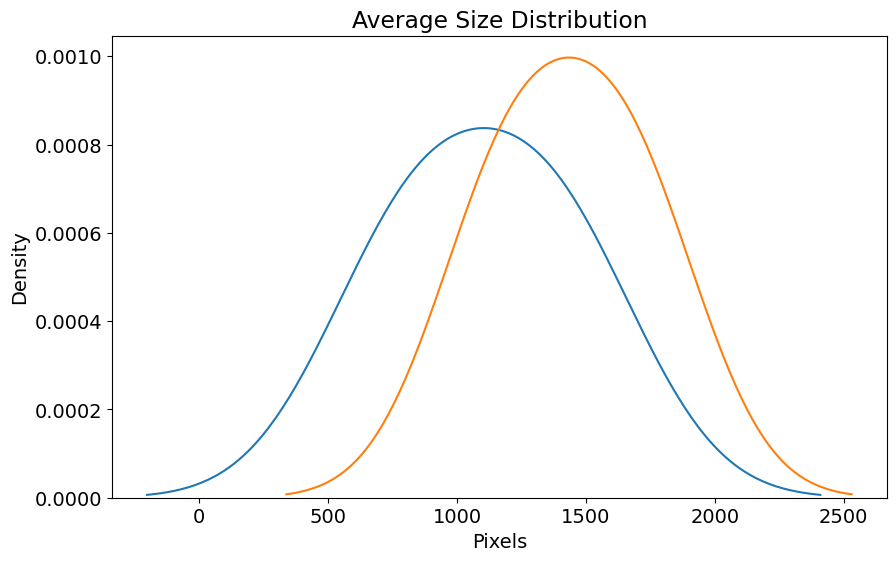

In [6]:
img_dsc = image_df.groupby('category').mean()
plt.figure(figsize=(10, 6))
sns.kdeplot(
    img_dsc['height'], label='Average Height')
sns.kdeplot(
    img_dsc['width'], label='Average Width')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Average Size Distribution')

In [7]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


(1013, 1528)

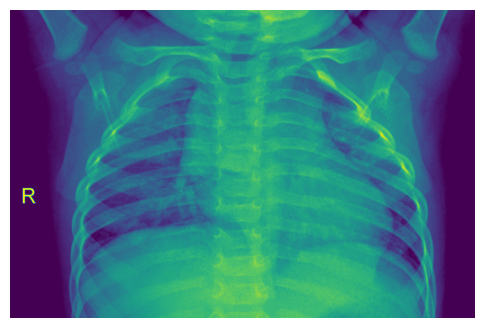

In [8]:
x = Image.open(traindir + 'NORMAL/IM-0128-0001.jpeg')
np.array(x).shape
imshow(x)

(863, 1244)

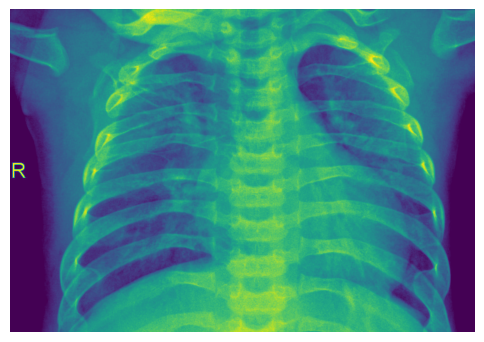

In [9]:
x = Image.open(traindir + 'PNEUMONIA/person1001_bacteria_2932.jpeg')
np.array(x).shape
imshow(x)

<a id='4'>4. Image Preprocessing</a>

#### Data Augmentation

To prepare the images for our network, we have to resize them to 224 x 224 and normalize each color channel by subtracting a mean value and dividing by a standard deviation. We will also augment our training data in this stage. These operations are done using image transforms, which prepare our data for a neural network.

**Data Augmentation**

To get more data, we just need to make minor alterations to our existing dataset. Minor changes such as flips or translations or rotations. Our neural network would think these are distinct images anyway. A convolutional neural network that can robustly classify objects even if its placed in different orientations is said to have the property called invariance. More specifically, a CNN can be invariant to translation, viewpoint, size or illumination (Or a combination of the above). This means for training, we randomly resize and crop the images and also flip them horizontally. A different random transformation is applied each epoch (while training), so the network effectively sees many different versions of the same image. All of the data is also converted to Torch Tensors before normalization. The validation and testing data is not augmented but is only resized and normalized. The normalization values are standardized for Imagenet.

In [10]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [12]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [13]:
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

There are 2 different classes.


2

<a id='6'>6. Using Pre-Trained Models for Image Classifications</a>

PyTorch has many pretrained models we can use. All of these models have been trained on Imagenet which consists of millions of images across 1000 categories. What we want to do with pretrained models is freeze the early layers, and replace the classification module with our own.

**Approach**

* Load in pre-trained weights from a network trained on a large dataset
* Freeze all the weights in the lower (convolutional) layers
* Layers to freeze can be adjusted depending on similarity of task to large training dataset
* Replace the classifier (fully connected) part of the network with a custom classifier
* Number of outputs must be set equal to the number of classes
* Train only the custom classifier (fully connected) layers for the task
* Optimizer model classifier for smaller dataset

In [14]:
model=models.vgg16()
model.load_state_dict(torch.load("/kaggle/input/pytorch-pretrained-models/vgg16-397923af.pth"))

<All keys matched successfully>

In [15]:
for param in model.parameters():
    param.requires_grad = False
    

Add on Custom Classifier
We'll train a classifier consisting of the following layers

* Fully connected with ReLU activation (n_inputs, 256)
* Dropout with 40% chance of dropping
* Fully connected with log softmax output (256, n_classes)

In [16]:
n_inputs = model.classifier[6].in_features

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [17]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,309,890 total parameters.
1,049,346 training parameters.


In [18]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model=models.vgg16()
        model.load_state_dict(torch.load("/kaggle/input/pytorch-pretrained-models/vgg16-397923af.pth"))

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    if multi_gpu:
        model = nn.DataParallel(model)

    return model

In [19]:
model = get_pretrained_model('vgg16')
if multi_gpu:
    summary(
        model.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 256, 56, 56]         590,080
             ReLU-14         [128, 256,

In [20]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'NORMAL'), (1, 'PNEUMONIA')]

In [21]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([2, 256])
torch.Size([2])


<a id='7'>7. Training the model</a>

For training, we iterate through the train DataLoader, each time passing one batch through the model. One complete pass through the training data is known as an epoch, and we train for a set number of epochs or until early stopping kicks in (more below). After each batch, we calculate the loss (with criterion(output, targets)) and then calculate the gradients of the loss with respect to the model parameters with loss.backward(). This uses autodifferentiation and backpropagation to calculate the gradients.

After calculating the gradients, we call optimizer.step() to update the model parameters with the gradients. This is done on every training batch so we are implementing stochastic gradient descent (or rather a version of it with momentum known as Adam). For each batch, we also compute the accuracy for monitoring and after the training loop has completed, we start the validation loop. This will be used to carry out early stopping.

In [22]:

def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            # calculate test accuracy for each object class
            '''for i in range(batch_size):       
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1'''
                
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)
            
            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [23]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=10,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 100.62 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 0.3443 	Validation Loss: 0.4740
		Training Accuracy: 84.76%	 Validation Accuracy: 68.75%
Epoch: 1	100.00% complete. 101.84 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.2476 	Validation Loss: 0.2489
		Training Accuracy: 89.65%	 Validation Accuracy: 93.75%
Epoch: 2	100.00% complete. 102.02 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.2336 	Validation Loss: 0.3419
		Training Accuracy: 90.18%	 Validation Accuracy: 87.50%
Epoch: 3	100.00% complete. 101.46 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.2240 	Validation Loss: 0.2455
		Training Accuracy: 91.10%	 Validation Accuracy: 93.75%
Epoch: 4	100.00% complete. 101.46 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.2179 	Validation Loss: 0.2745
		Training Accuracy: 91.05%	 Validation Accuracy: 93.75%
Epoch: 5	100.00% complete. 101.37 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.2062 	Vali

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

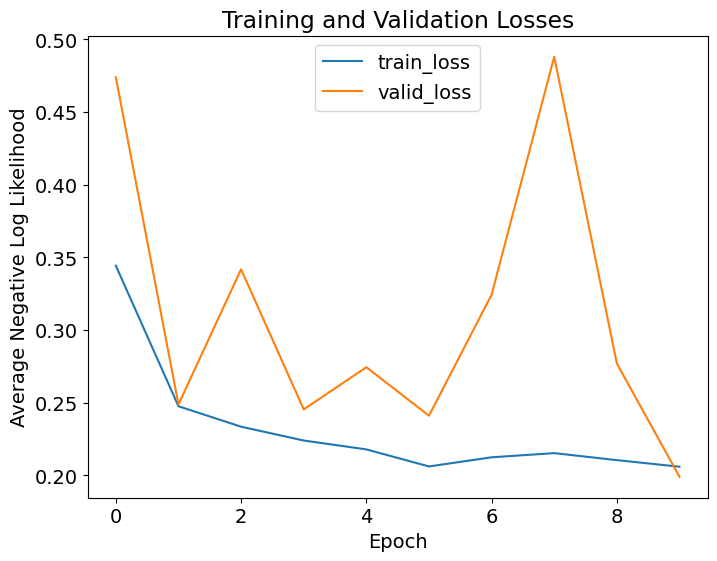

In [24]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

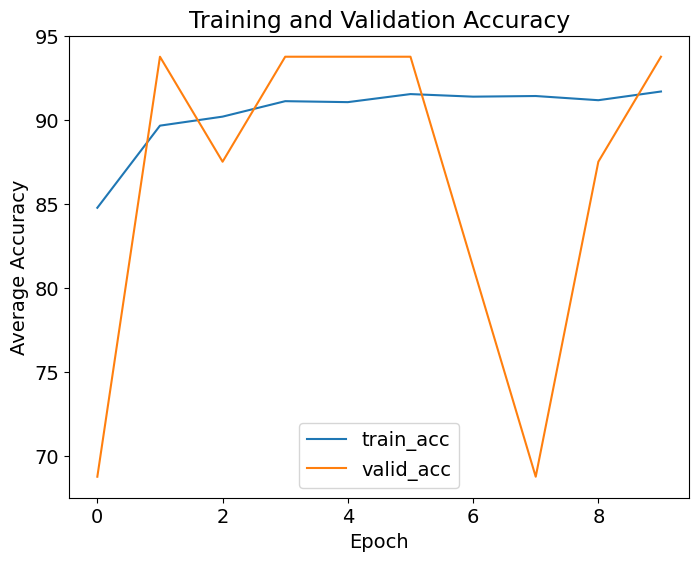

In [25]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [26]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [27]:
save_checkpoint(model, path=checkpoint_path)

In [28]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path, weights_only=False)

    if model_name == 'vgg16':
        model=models.vgg16()
        model.load_state_dict(torch.load("/kaggle/input/pytorch-pretrained-models/vgg16-397923af.pth"))
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    
    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer
model, optimizer = load_checkpoint(path=checkpoint_path)

if multi_gpu:
    summary(model.module, input_size=(3, 224, 224), batch_size=batch_size)
else:
    summary(model, input_size=(3, 224, 224), batch_size=batch_size)

135,309,890 total parameters.
1,049,346 total gradient parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 2

In [29]:
test_loader=dataloaders['test']
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
classes = [0,1]
model.eval()
i=1
# iterate over test data
len(test_loader)
for data, target in test_loader:
    i=i+1
    if len(target)!=batch_size:
        continue
        
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
#     print(target)
    
    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

5

Test Loss: 0.340744

Test Accuracy of     0: 65% (123/188)
Test Accuracy of     1: 95% (308/324)

Test Accuracy (Overall): 84% (431/512)
